Our last Learning Machines assignment is to calibrate the hyperparameters for a Multilayer Perceptron. Patrick gave us a working model using the MNIST database of handwritten digits. The model uses a Restricted Boltzmann Machine to reduce the dimensionality of the data and then a Multilayer Perceptron to classify the digits.

I was able to achieve an out-of-sample accuracy of almost 96%. This is in line with the results of [other researchers](http://yann.lecun.com/exdb/mnist/).

<!-- TEASER_END -->

I made some changes to Patrick's code to help me better understand the model performance but not in a way that alters the assignment.

In [1]:
%matplotlib inline

from Mnist import *
from Supervised import *
from Unsupervised import *
import numpy as np

np.set_printoptions(precision=3, suppress=True)

np.random.seed(0)

First I load the data and divide up the data into training, validation, and test datasets.

In [2]:
mnist_use_threshold = False

mnist_num_training_examples = 10000
mnist_num_validation_examples = 5000
mnist_num_testing_examples = 5000

mnist = Mnist(mnist_use_threshold)

training_digits, training_labels = mnist.getTrainingData(mnist_num_training_examples)
validation_digits, validation_labels = mnist.getValidationData(mnist_num_validation_examples)
testing_digits, testing_labels = mnist.getTestingData(mnist_num_testing_examples)

I completed this assignment in two phases. The first phase was to calibrate the parameters of the Restricted Boltzmann Machine. I wanted to reduce the dimensionality of the data as I've done in the past with PCA. I didn't want to compromise the data and undermine the Multilayer Perceptron, so I wanted to keep the error rate as low as possible.

The parameters I used are:

In [3]:
# RBM hyperparameters:
rbm_is_continuous = True
rbm_visible_size = 784
rbm_hidden_size = 200
rbm_batch_size = 250
rbm_learn_rate = 0.25
rbm_cd_steps = 3
rbm_training_epochs = 500
rbm_report_freq = 1
rbm_report_buffer = rbm_training_epochs

Using these parameters I can create and train a Restricted Boltzmann Machine.

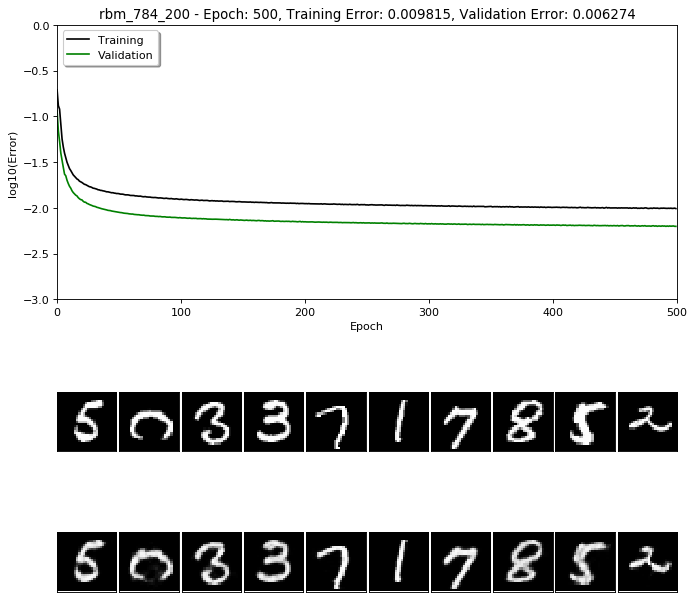

In [4]:
rbm_name = 'rbm_' + str(rbm_visible_size) + '_' + str(rbm_hidden_size)
rbm = Rbm(rbm_name, rbm_visible_size, rbm_hidden_size, rbm_is_continuous)
rbm.train(training_digits, validation_digits, rbm_learn_rate, rbm_cd_steps,
          rbm_training_epochs, rbm_batch_size, rbm_report_freq, rbm_report_buffer)

I changed Patrick's code to plot the log error to better see improvements in the error rate. I see that after a few hundred epochs the error rate barely diminishes. Interestingly, the validation error is smaller than the training error.

The display of several handwritten digits is helpful. The top layer are original database digits. The bottom layer are digits that have been encoded and decoded. They look almost the same as the original. This means I was able to reduce the dimensionality of the data without compromising the integrity of the handwritten digits.

Next I use the Restricted Boltzmann Machine to encode the dataset. This effectively reduces the dimensionality of the data to 200 data points. These encodings will become the input to the Multilayer Perceptron.

In [5]:
_, training_encodings = rbm.getHiddenSample( training_digits )
_, validation_encodings = rbm.getHiddenSample( validation_digits )
_, testing_encodings = rbm.getHiddenSample( testing_digits )

Below are the parameters I used for the Multilayer perceptron. There is only one hidden layer with 150 nodes. This is somewhat smaller than the 200-value input layer.

In [6]:
mlp_layer_sizes = [ rbm_hidden_size, 150, 10 ]
mlp_batch_size = 250
mlp_learn_rate = 0.5
mlp_training_epochs = 2000
mlp_report_freq = 1
mlp_report_buffer = mlp_training_epochs

Next I create and train the Multilayer Perceptron.

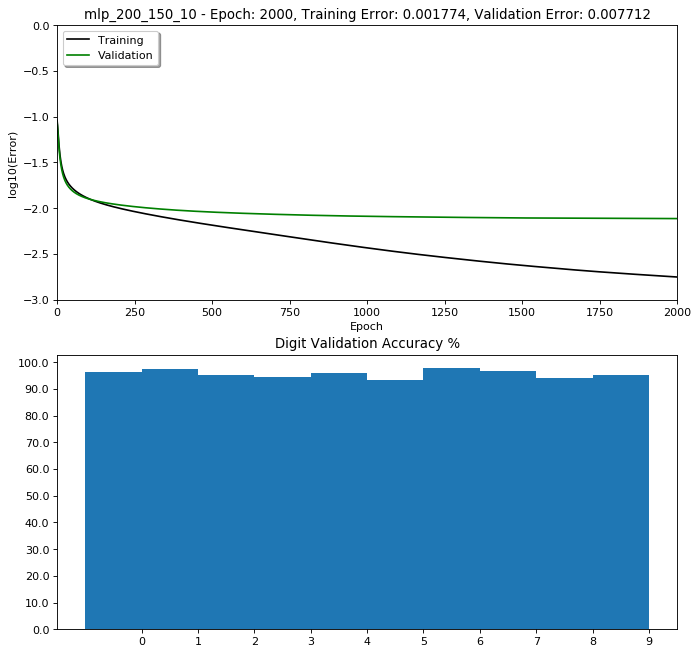

In [7]:
mlp_name = 'mlp_' + '_'.join( str(i) for i in mlp_layer_sizes )
mlp = Mlp( mlp_name, mlp_layer_sizes, 'sigmoid' )
mlp.train( training_encodings, training_labels, validation_encodings,
          validation_labels, mlp_learn_rate, mlp_training_epochs,
          mlp_batch_size, mlp_report_freq, mlp_report_buffer )

After 500 or so iterations the training error declines while the validation error remains steady. It seems that the model is starting to overfit the data. 

How well does the model work on an out-of-sample dataset? I can measure to find out.

In [8]:
testing_guesses = mlp.predict( testing_encodings )
testing_error = mlp.getErrorRate( testing_labels, testing_guesses )
testing_accuracy = mnist_get_accuracy( testing_labels, testing_guesses )
print ('Final Testing Error Rate: %f' % ( testing_error ))
print ('Final Testing Accuracy: %f' % ( testing_accuracy ))

Final Testing Error Rate: 0.007759
Final Testing Accuracy: 0.956400


Almost 96%. That's reasonably good for this dataset, although I recall fitting neural networks to this in the past and getting closer to 99%. To achieve that here I think I'd need to do more than adjust the model hyperparameters. There are regularization techiques for neural networks such as [dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks) that can help with overfitting, and I think they'd be useful here.